In [1]:
#importing neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

Task : Classifying as Spam-Ham based on texts <br>
Dataset used : SMS Spam Collection Dataset <br>
Source : Kaggle<br>
URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

#### Reading Dataset

In [2]:
df = pd.read_csv(r"spam.csv",encoding_errors= 'replace')

In [3]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


### Exploratory Data Analysis

#### Dropping unneccesary columns

In [4]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis="columns",inplace=True)

In [5]:
df.rename(columns={"v1":"Class","v2":"Text"},inplace= True)

#### Given text are in collaquial english i.e. informal text

In [6]:
df.sample(5)

,Class,Text
4658,ham,I cant pick the phone right now. Pls send a me...
1421,ham,Do you work all this week ?
4758,spam,Thanks 4 your continued support Your question ...
3701,ham,Hey loverboy! I love you !! I had to tell ... ...
3188,ham,X2 &lt;#&gt; . Are you going to get that


#### Distribution of Data

In [7]:
df.Class.value_counts()/len(df)*100

ham     86.593683
spam    13.406317
Name: Class, dtype: float64

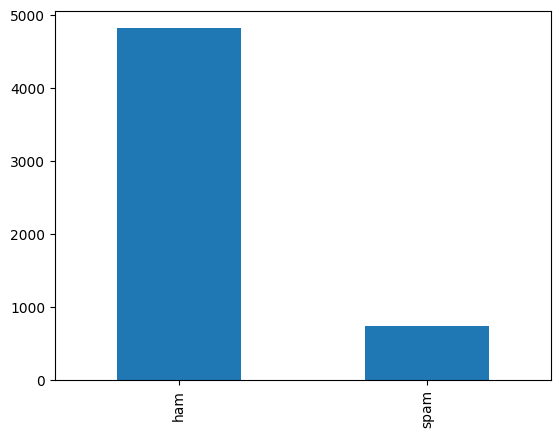

In [8]:
df.Class.value_counts().plot.bar();

#### Checking for duplicate columns and dropping them

In [9]:
df.duplicated().sum()

403

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.reset_index(inplace=True,drop=True)

#### Counting length of each text

In [12]:
df['length'] = df['Text'].apply(len)

In [13]:
df.sample(5)

,Class,Text,length
1680,ham,I will come tomorrow di,23
1350,ham,"Haha just kidding, papa needs drugs",35
1561,spam,RT-KIng Pro Video Club>> Need help? info@ringt...,153
1749,ham,"Aight, I'll ask a few of my roommates",37
2029,ham,Thank you. I like you as well...,32


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   5169 non-null   object
 1   Text    5169 non-null   object
 2   length  5169 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [15]:
df.describe(include="all")

,Class,Text,length
count,5169,5169,5169.000000
unique,2,5169,NaN
top,ham,"Go until jurong point, crazy.. Available only ...",NaN
freq,4516,1,NaN
mean,NaN,NaN,78.923776
std,NaN,NaN,58.174846
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,60.000000
75%,NaN,NaN,117.000000


In [16]:
## Displaying top 10 spam texts
df[df['Class']=="spam"][:10]

,Class,Text,length
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147
8,spam,WINNER!! As a valued network customer you have...,157
9,spam,Had your mobile 11 months or more? U R entitle...,154
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136
12,spam,URGENT! You have won a 1 week FREE membership ...,155
15,spam,"XXXMobileMovieClub: To use your credit, click ...",149
19,spam,England v Macedonia - dont miss the goals/team...,155
34,spam,Thanks for your subscription to Ringtone UK yo...,158
42,spam,07732584351 - Rodger Burns - MSG = We tried to...,172


In [17]:
## Displaying top 10 ham texts
df[df['Class']=="ham"][:10]

,Class,Text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
10,ham,I'm gonna be home soon and i don't want to tal...,109
13,ham,I've been searching for the right words to tha...,196
14,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,35
16,ham,Oh k...i'm watching here:),26


In [18]:
## Average length of spam and ham messages
spam_mean = np.mean(df["length"][df['Class']=="spam"])
ham_mean = np.mean(df["length"][df['Class']=="ham"])

In [19]:
pd.DataFrame({"Message":["Spam","Ham"],"Length":[spam_mean,ham_mean]})

,Message,Length
0,Spam,137.479326
1,Ham,70.456820


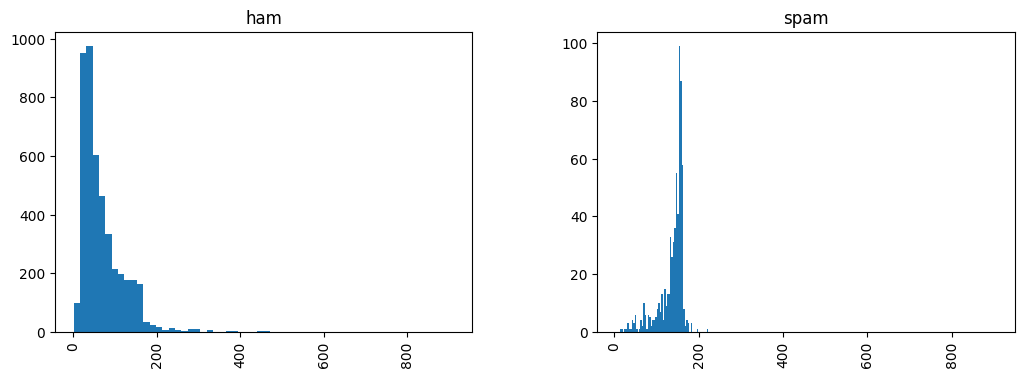

In [20]:
df.hist(column='length',by='Class',bins=60,figsize=(12,4));
plt.xlim(-40,950);

### Data Cleaning 

In [21]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [22]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_URL(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_URL(text)
    text = remove_stopwords(text)
    text = text.lower()
    return text

#Apply function on review column
df['Text']=df['Text'].apply(denoise_text)

C:\Users\Juhi\AppData\Local\Temp\ipykernel_23640\2568861621.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Applying Lemming

In [23]:
lemmatizer = WordNetLemmatizer()
def lemming(content):
    tokens = word_tokenize(content)
    lemmed_content = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmed_content

In [24]:
df['lemmetized_review'] = df['Text'].apply(lemming)

In [25]:
df.sample(6)

,Class,Text,length,lemmetized_review
1982,ham,ugh fuck resubbing eve,32,"[ugh, fuck, resubbing, eve]"
3780,ham,,36,[]
3983,ham,juz havent woke bit blur dad went cant cum,92,"[juz, havent, woke, bit, blur, dad, went, cant..."
1469,ham,shall ask one thing dont mistake,45,"[shall, ask, one, thing, dont, mistake]"
1828,spam,call listen extreme dirty live chat going offi...,163,"[call, listen, extreme, dirty, live, chat, goi..."
980,ham,say anything,26,"[say, anything]"


#### Displaying Wordcloud

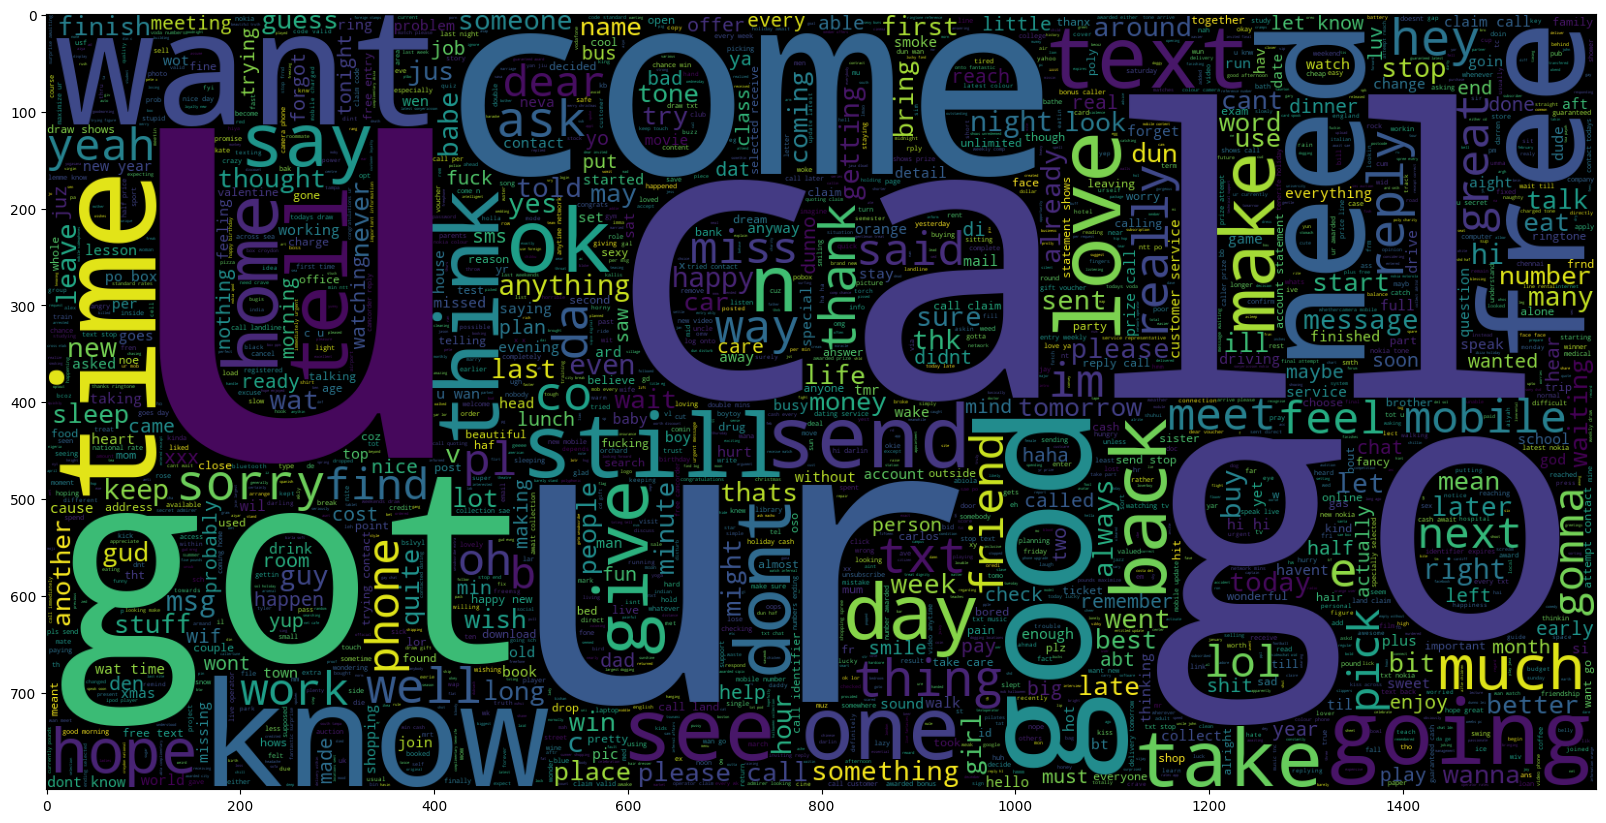

In [26]:
plt.figure(figsize = (20,20)) # Text that is not Spam
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df.Text))
plt.imshow(wc)

#### Label encoding class variable

In [27]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['Class']= label_encoder.fit_transform(df['Class'])

#### 0 signifies Ham and 1 signifies Spam

In [28]:
df.Class.value_counts()

0    4516
1     653
Name: Class, dtype: int64

### Train-Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Class'], test_size = 0.1, random_state = 1)

In [35]:
print("X_train shape: {}\nX_test shape: {}\nY_train shape: {}\nY_test shape: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train shape: (4652,)
X_test shape: (517,)
Y_train shape: (4652,)
Y_test shape: (517,)


### Tf-Idf Vectorizer

In [36]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Implementing models

In [62]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [84]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          GaussianNB(),
          SVC()]

In [87]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, X_train.toarray(), y_train, scoring='roc_auc', 
                                cv= StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

In [88]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB',"SVM"]

accuracy_df = pd.DataFrame({'Model': models_name, 'ROC_AUC': accuracy})
accuracy_df

,Model,Roc_Auc
0,DecisionTreeClassifier,0.882218
1,RandomForestClassifier,0.979379
2,LogisticRegression,0.976640
3,KNeighborsClassifier,0.778106
4,BernoulliNB,0.815525
5,SVM,0.981978


### Result

As it's an imbalanced dataset, use of accuracy as a metrics isn't appropriate and hence , ROC_AUC score has been used here
We obtain the best results when SVM model is used with a score of 98.19%